In [1]:
import numpy as np
import os, sys
import argparse, time
import torch
from torch.autograd import Variable
# from dataset.kitti_dataset import KittiDataset
from torchvision.transforms import RandomHorizontalFlip, ToPILImage
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
# from path import Path
from torch.utils.data.sampler import Sampler
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
from model_fpn import I2D

def adjust_learning_rate(optimizer, decay=0.1):
    """Sets the learning rate to the initial LR decayed by 0.5 every 20 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = decay * param_group['lr']

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

class SLlog(nn.Module):
    def __init__(self):
        super(SLlog, self).__init__()
    
    def forward(self, fake, real):
        if not fake.shape == real.shape:
            _,_,H,W = real.shape
            fake = F.upsample(fake, size=(H,W), mode='bilinear')
            
        # filter out invalid pixels
        N = (real>0).float().sum()
        mask = (real==0)        
        fake[mask] = 1.
        real[mask] = 1.
        
        loss = 100.* torch.sum( torch.abs(torch.log(real)-torch.log(fake)) ) / N
        return loss

    
class RMSE_log(nn.Module):
    def __init__(self, use_cuda):
        super(RMSE_log, self).__init__()
        self.eps = 1e-8
        self.use_cuda = use_cuda
    
    def forward(self, fake, real):
        mask = real<1.
        n,_,h,w = real.size()
        fake = F.upsample(fake, size=(h,w), mode='bilinear')
        fake += self.eps

        N = len(real[mask])
        loss = torch.sqrt( torch.sum( torch.abs(torch.log(real[mask])-torch.log(fake[mask])) ** 2 ) / N )
        return loss

class iRMSE(nn.Module):
    def __init__(self):
        super(iRMSE, self).__init__()
        self.eps = 1e-8
    
    def forward(self, fake, real):
        n,_,h,w = real.size()
        fake = F.upsample(fake, size=(h,w), mode='bilinear')
        mask = real<1.
        n = len(real[mask])
        loss = torch.sqrt( torch.sum( torch.abs(1./real[mask] - 1./(fake[mask]+self.eps) ) ** 2 ) / n )
        return loss

def get_acc(output, target):
    # takes in two tensors to compute accuracy
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct_mask = pred.eq(target.data.view_as(pred))
    correct = correct_mask.cpu().sum()
    print("Target: ", Counter(target.data.cpu().numpy()))
    print("Pred: ", Counter(pred.cpu().numpy().flatten().tolist()))
    return float(correct)*100 / target.size(0) 
    

In [2]:
# network initialization
print('Initializing model...')
i2d = I2D(fixed_feature_weights=False)

print('Done!')

reg_criterion = RMSE_log(use_cuda=True)
eval_metric = iRMSE()

# resume

load_name = 'saved_models/i2d_1_0.pth'
print("loading checkpoint %s" % (load_name))
state = i2d.state_dict()
checkpoint = torch.load(load_name, map_location='cpu')
state.update(checkpoint['model'])
i2d.load_state_dict(state)

del checkpoint

# setting to train mode
i2d.eval()



Initializing model...
Done!
loading checkpoint saved_models/i2d_1_0.pth


I2D(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0)

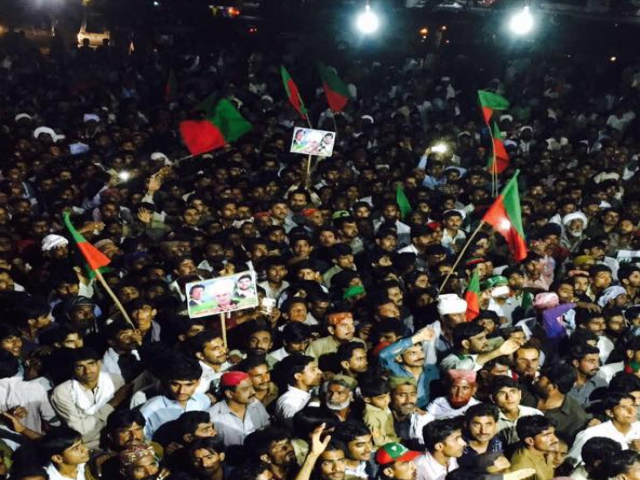

/usr/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


people = 0.0 max = 0.0


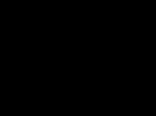

people = 359.90289306640625 max = 0.1996546983718872


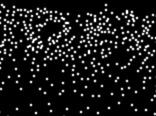

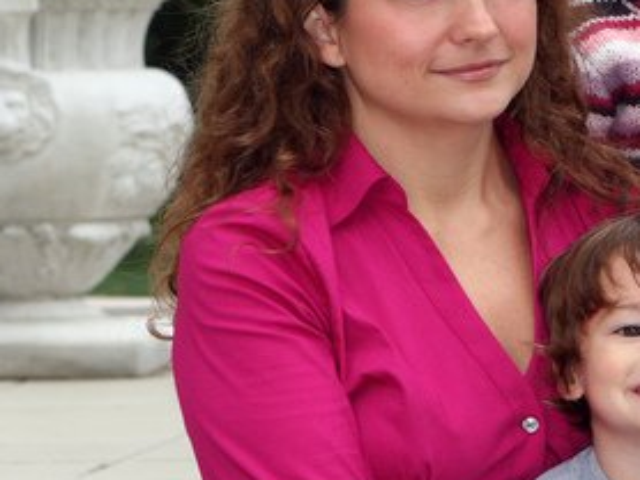

people = 0.0 max = 0.0


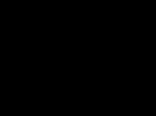

people = 0.8265053629875183 max = 0.0003257220087107271


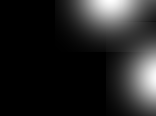

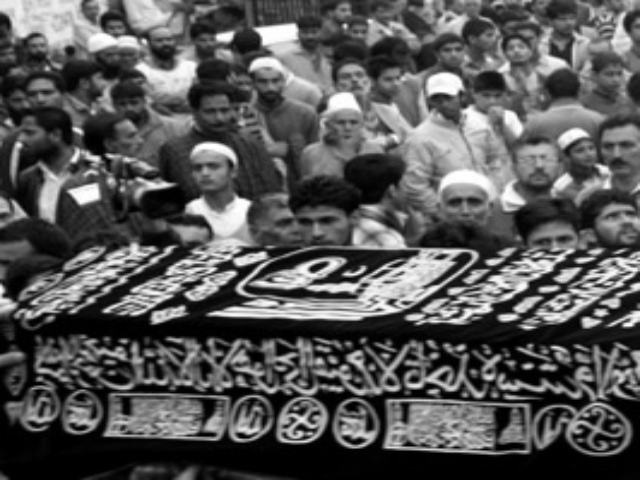

people = 0.0 max = 0.0


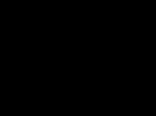

people = 64.99908447265625 max = 0.060618914663791656


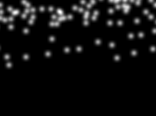

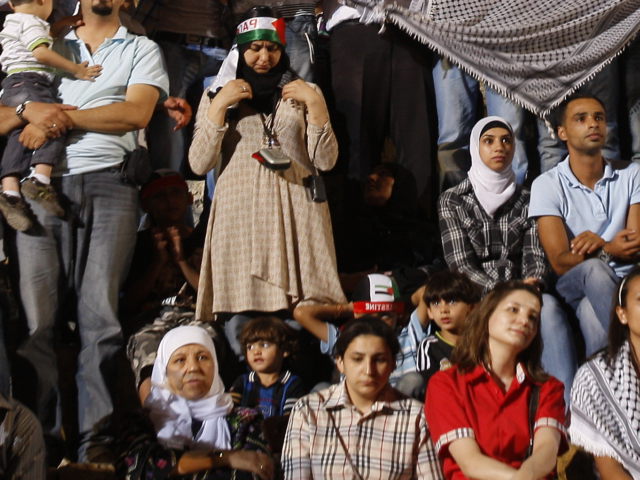

people = 0.0 max = 0.0


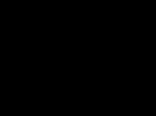

people = 9.630743026733398 max = 0.04909272491931915


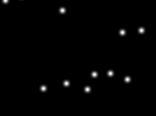

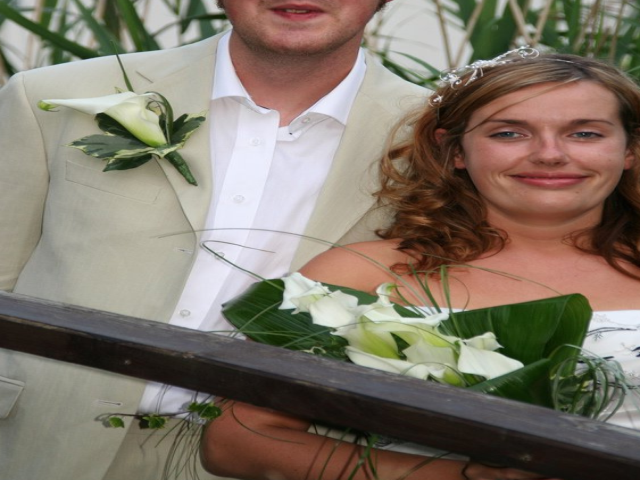

people = 0.0 max = 0.0


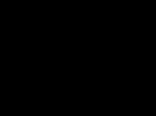

people = 1.198427438735962 max = 0.0010589867597445846


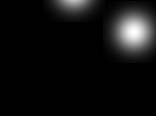

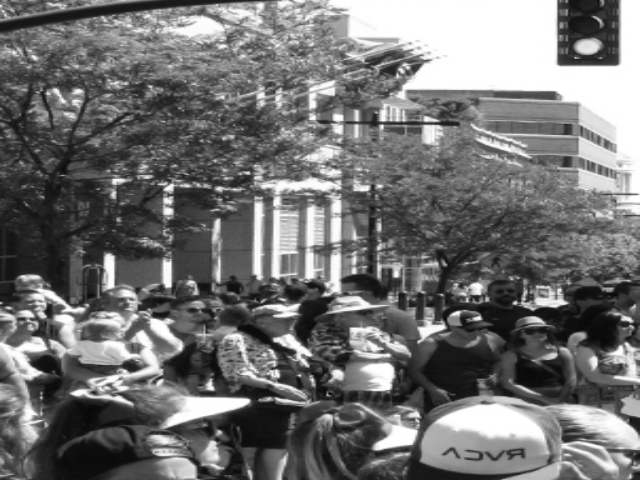

people = 0.0 max = 0.0


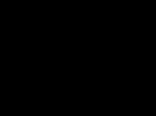

people = 44.48625183105469 max = 0.05588969588279724


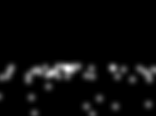

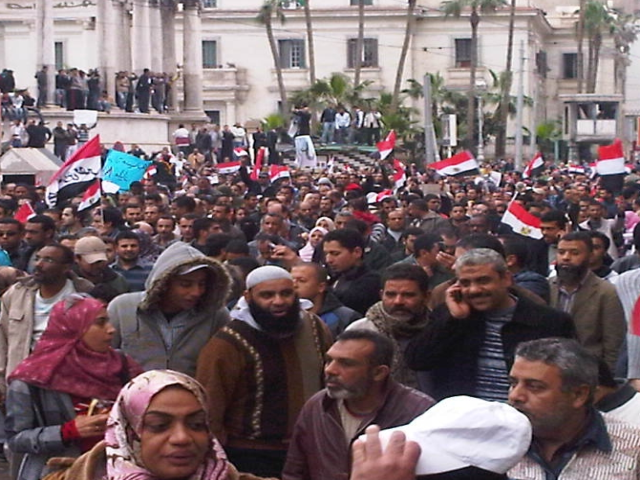

people = 0.0 max = 0.0


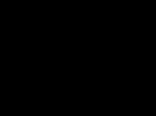

people = 336.0000305175781 max = 0.5688959956169128


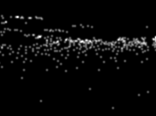

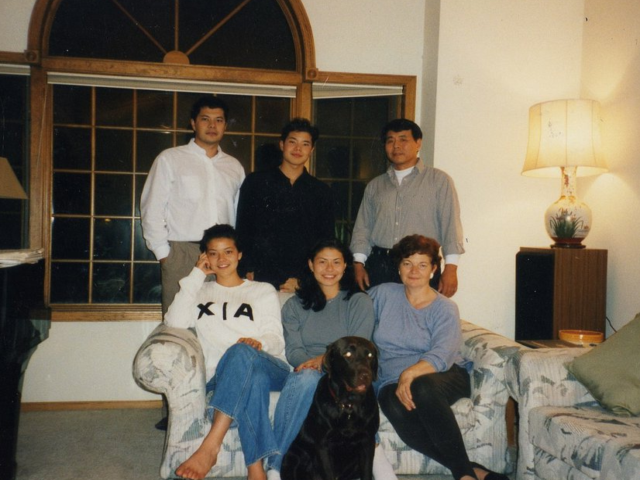

people = 0.0 max = 0.0


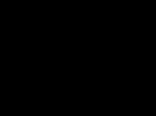

people = 6.0 max = 0.004235947038978338


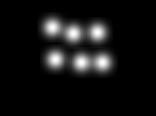

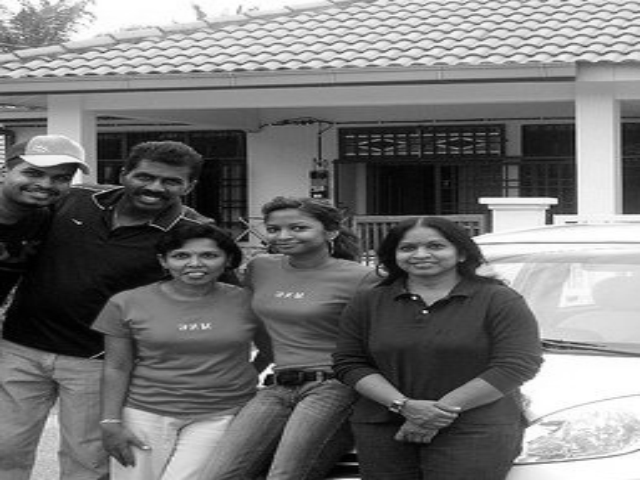

people = 0.0 max = 0.0


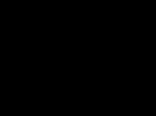

people = 4.9386396408081055 max = 0.0023347516544163227


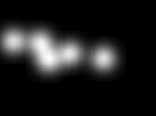

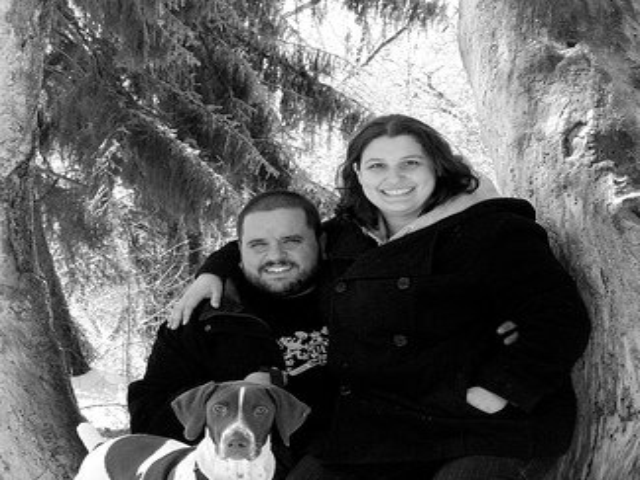

people = 0.0 max = 0.0


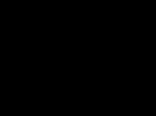

people = 2.0 max = 0.001052279258146882


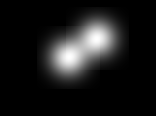

In [3]:
import torchvision

import torch
from dataset.custom import CustomDataset

vis_dataset = CustomDataset(train=True)
train_size = len(vis_dataset)

bs = 1
vis_dataloader = torch.utils.data.DataLoader(vis_dataset, batch_size=bs, shuffle=True)
vis_data_iter = iter(vis_dataloader)
transform = torchvision.transforms.ToPILImage()

def display_density(t: torch.Tensor):
    #t = t[:, 3:-3, 3:-3]
    people = t.sum()
    print('people = {} max = {}'.format(people, t.max()))
    t = t/t.max()
    display(transform(t))

for i in range(10):
    img, z = vis_data_iter.next()
    display(transform(img[0]))
    
    if True:
        with torch.no_grad():
            z_fake = i2d(img)
            display_density(z_fake[0])
        
    display_density(z[0])


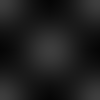

In [17]:
import numpy as np
import scipy.stats as st

def gkern(kernlen, nsig):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return torch.from_numpy(kern2d/kern2d.sum()).float()

def add_to(density, dist, y, x):
    h, w = dist.shape
    
    l = 0
    r = w
    b = 0
    t = h
    
    bottom = int(y-h/2)
    top = bottom + h
    left = int(x-w/2)
    right = left + w
    
    if bottom < 0:
        b += -bottom
        bottom = 0
    if top > density.shape[0]:
        t -= top-density.shape[0]
        top = density.shape[0]
    if left < 0:
        l += -left
        left = 0
    if right > density.shape[1]:
        r -= right-density.shape[1]
        right = density.shape[1]
    if b <= t and l <= r:
        density[bottom:top, left:right] += dist[b:t, l:r]
        
dist = gkern(100, 2.5)*600
density = torch.zeros((100, 100))
add_to(density, dist, 100, 100)
add_to(density, dist, 0, 0)
add_to(density, dist, 0, 100)
add_to(density, dist, 100, 0)
add_to(density, dist, -100, -100)

dist = gkern(101, 2.5)*600
add_to(density, dist, 50, 50)
display(transform(density))